In [1]:
# imports 

from torchvision.datasets import VOCDetection
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import torchvision
from torch.nn import functional as Func


import matplotlib.pyplot as plt

import numpy as np
import torch

import albumentations as A
from timm.models.resnet import resnet18

/home/phil/.local/share/virtualenvs/centernet_showcase-TdzlU0Pi/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset works

train_dataset = VOCDetection(
    root='./data/train',
    image_set='train',
    download=True,
    transform=None,
)

valid_dataset = VOCDetection(
    root='./data/valid',
    image_set='val',
    download=True,
    transform=None,
)

Using downloaded and verified file: ./data/train/VOCtrainval_11-May-2012.tar
Extracting ./data/train/VOCtrainval_11-May-2012.tar to ./data/train
Using downloaded and verified file: ./data/valid/VOCtrainval_11-May-2012.tar
Extracting ./data/valid/VOCtrainval_11-May-2012.tar to ./data/valid


In [3]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=500x442>,
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000008.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '442', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'occluded': '1',
     'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
     'difficult': '0'},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
     'difficult': '0'}]}})

In [4]:
example = np.array(train_dataset[0][0])
example = example.transpose(2, 0, 1)
example = torch.from_numpy(example)

In [5]:
bounding_boxes = [
    [eval(x['bndbox']['xmin']), eval(x['bndbox']['ymin']), eval(x['bndbox']['xmax']), eval(x['bndbox']['ymax'])] 
    for x in train_dataset[0][1]['annotation']['object']
]
bounding_boxes = torch.tensor(bounding_boxes)

In [6]:
bounding_boxes

tensor([[ 53,  87, 471, 420],
        [158,  44, 289, 167]])

In [7]:
drawn_boxes = draw_bounding_boxes(example, bounding_boxes, colors="red")

In [8]:
plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

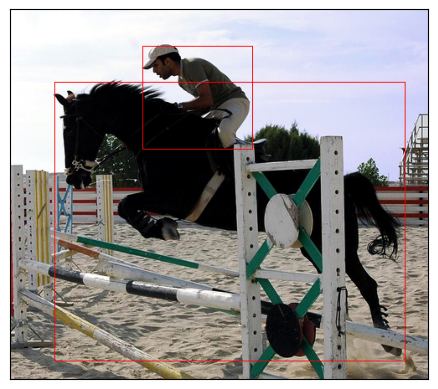

In [9]:
show(drawn_boxes)

In [10]:
# parameters

MAX_OBJECTS = 10
HEATMAP_RADIUS = 2

In [219]:
# encoding centernet heatmaps and offsets

# let heatmap be [1, H, W]
# and offset map be [2, H, W] with [x, y] offset on corresponding channel

def encode_heatmap_and_offset(image_hw, cxcyhw_bounding_boxes, stride, sigma=HEATMAP_RADIUS):
    xy_coordinates = cxcyhw_bounding_boxes[:, :2]

    H, W = image_hw
    N = xy_coordinates.shape[0]

    H_meshgrid, W_meshgrid = torch.meshgrid(torch.linspace(0, H - 1, H), torch.linspace(0, W - 1, W))
    grid = torch.stack((W_meshgrid, H_meshgrid), dim=2)
    
    grid = grid.unsqueeze(0).repeat(N, 1, 1, 1)
    
    keypoints_unsq = xy_coordinates.unsqueeze(1).unsqueeze(1)
    keypoints_to_stride = torch.floor(keypoints_unsq / stride)

    difference = ((grid - keypoints_to_stride) ** 2)
    heatmap = torch.exp(-torch.sum(difference, dim=-1) / (2 * sigma**2))
    heatmap = torch.sum(heatmap, dim=0)

    offset = keypoints_unsq - keypoints_to_stride * stride
    offset = offset.squeeze(1).squeeze(1)
    offset_int = (xy_coordinates / stride).int()

    offset_map = torch.zeros((2, H, W))
    offset_map[0, offset_int[:, 1].int(), offset_int[:, 0].int()] = offset[:, 0]
    offset_map[1, offset_int[:, 1].int(), offset_int[:, 0].int()] = offset[:, 1]

    return heatmap, offset_map, keypoints_to_stride


def decode_heatmap_and_offset(heatmap):
    pass


def xyxy_to_cxcyhw(bounding_boxes):
    h = bounding_boxes[:, 3] - bounding_boxes[:, 1]
    w = bounding_boxes[:, 2] - bounding_boxes[:, 0]

    cx = (bounding_boxes[:, 0] + bounding_boxes[:, 2]) // 2
    cy = (bounding_boxes[:, 1] + bounding_boxes[:, 3]) // 2

    return torch.cat([cx.view(-1, 1), cy.view(-1, 1), h.view(-1, 1), w.view(-1, 1)], dim=1)
    

In [220]:
# writing custom dataset for centernet

class CustomCenterNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, image_set, transform=None, stride=1):
        self.dataset = VOCDetection(
            root=root_path,
            image_set=image_set,
            download=False,
            transform=None
        )

        self.transform = transform
        self.stride = stride

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        image = np.array(item[0])

        bounding_boxes = [
            [eval(x['bndbox']['xmin']), eval(x['bndbox']['ymin']), eval(x['bndbox']['xmax']), eval(x['bndbox']['ymax'])] 
            for x in item[1]['annotation']['object']
        ]
        bounding_boxes = bounding_boxes[:MAX_OBJECTS]

        transformed = self.transform(image=image, bboxes=bounding_boxes)
        image, bounding_boxes = transformed['image'], transformed['bboxes']
        image = torch.from_numpy(image).permute(2, 0, 1)
        bounding_boxes = torch.tensor(bounding_boxes).float()

        cxcyhw_bbs = xyxy_to_cxcyhw(bounding_boxes)

        objectness_heatmap, offset_map, keypoints_stride = encode_heatmap_and_offset((image.shape[1]//self.stride, image.shape[2]//self.stride), cxcyhw_bbs, stride=self.stride)
        hw_padded = bounding_boxes[:, 2:]
        N_masks_used = hw_padded.shape[0]
        _zero_padding = torch.zeros(max(0, MAX_OBJECTS-hw_padded.shape[0]), 2)
        hw_padded = torch.cat([hw_padded, _zero_padding], dim=0) // self.stride
        hw_mask = torch.cat([torch.ones((N_masks_used, 1)), torch.zeros((MAX_OBJECTS-N_masks_used, 1))], dim=0) 
        keypoints_stride_padded = torch.cat([keypoints_stride.squeeze(1).squeeze(1), _zero_padding], dim=0) 

        # plt.imshow(offset_map[0])
        # plt.show()
        # plt.imshow(offset_map[1])
        # plt.show()
        # plt.imshow(objectness_heatmap)
        # plt.show()
        # show(draw_bounding_boxes(image, bounding_boxes))
        return {
            'image': image.float(),
            'objectness_heatmap': objectness_heatmap,
            'keypoints_stride': keypoints_stride_padded,
            'offset_map': offset_map,
            'hw_mask': hw_mask,
            'hw_map': hw_padded
        }
        
        

In [221]:
train_dataset = CustomCenterNetDataset(
    './data/train/',
    'train',
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Resize(height=512, width=512, p=1)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[])),
    stride=4
)

In [222]:
train_dataset[2]

{'image': tensor([[[ 74.,  76.,  78.,  ...,  79.,  78.,  77.],
          [ 75.,  76.,  78.,  ...,  79.,  78.,  77.],
          [ 78.,  77.,  76.,  ...,  79.,  78.,  76.],
          ...,
          [ 93.,  83.,  79.,  ...,  80.,  78.,  78.],
          [ 99.,  85.,  79.,  ...,  79.,  77.,  76.],
          [102.,  87.,  78.,  ...,  78.,  77.,  76.]],
 
         [[ 82.,  84.,  87.,  ...,  86.,  85.,  84.],
          [ 83.,  84.,  86.,  ...,  86.,  85.,  84.],
          [ 86.,  85.,  84.,  ...,  86.,  85.,  83.],
          ...,
          [100.,  90.,  86.,  ...,  86.,  84.,  84.],
          [106.,  92.,  85.,  ...,  85.,  83.,  82.],
          [109.,  93.,  85.,  ...,  85.,  83.,  82.]],
 
         [[ 85.,  87.,  89.,  ...,  92.,  91.,  90.],
          [ 86.,  87.,  89.,  ...,  92.,  91.,  90.],
          [ 89.,  88.,  87.,  ...,  92.,  91.,  89.],
          ...,
          [110., 100.,  96.,  ..., 102., 100., 100.],
          [116., 102.,  95.,  ..., 101.,  99.,  98.],
          [119., 104.,

In [223]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

In [224]:
for batch in train_dataloader:
    print(batch['objectness_heatmap'].shape)
    print(batch['offset_map'].shape)
    print(batch['hw_mask'].shape)
    print(batch['hw_map'].shape)
    break

torch.Size([16, 128, 128])
torch.Size([16, 2, 128, 128])
torch.Size([16, 10, 1])
torch.Size([16, 10, 2])


In [225]:
# implement the CenterNet

class UpsampleBlock(torch.nn.Module):
    def __init__(self, upsample_factor, in_block_channels, output_block_channels):
        super().__init__()
        self.block = torch.nn.Sequential(
            torch.nn.UpsamplingBilinear2d(scale_factor=upsample_factor),
            torch.nn.Conv2d(in_channels=in_block_channels, out_channels=in_block_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=in_block_channels, out_channels=output_block_channels, kernel_size=3, padding=1),
            torch.nn.ReLU()
        )
    def forward(self, fm):
        return self.block(fm)

class SimpleHeatmapHead(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs=1):
        super().__init__()
        self.head = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_inputs, out_channels=n_outputs, kernel_size=1, padding=0),
        )
    def forward(self, fm):
        return self.head(fm)

class RegressionHead(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        # [B C fh fw] -> ... -> [B, 1, fh, fw]
        self.fc = torch.nn.Sequential(
            torch.nn.Conv2d(
                n_inputs, n_inputs, kernel_size=3, padding=1, bias=True
            ),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(n_inputs, n_outputs, kernel_size=1, stride=1, padding=0),
        )
    def forward(self, fm):
        return self.fc(fm)

def gather_feature(fmap, index, use_transform=False):
    if use_transform:
        # change a (N, C, H, W) tenor to (N, HxW, C) shape
        batch, channel = fmap.shape[:2]
        fmap = fmap.view(batch, channel, -1).permute((0, 2, 1)).contiguous()
        
    dim = fmap.size(-1)
    index = index.unsqueeze(len(index.shape)).expand(*index.shape, dim)
    fmap = fmap.gather(dim=1, index=index)
    
    return fmap

class CenterNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = resnet18(pretrained=True, features_only=True)
        self.upsample_blocks = torch.nn.ModuleList([
            UpsampleBlock(2, 512, 256),  # 32 -> 16
            UpsampleBlock(2, 256, 128),  # 16 -> 8
            UpsampleBlock(2, 128, 64),   # 8 -> 4
        ])
        self.heatmap_head = SimpleHeatmapHead(64, 1)
        self.offset_head = SimpleHeatmapHead(64, n_outputs=2)

        self.hw_regression_head = RegressionHead(64, 2)

    def pool_nms(self, hm, pool_size=3):
        pad = (pool_size - 1) // 2
        hm_max = Func.max_pool2d(hm, pool_size, stride=1, padding=pad)
        keep = (hm_max == hm).float()
        return hm * keep

    def topk_score(self, scores, K):
        batch, channel, height, width = scores.shape

        # get topk score and its index in every H x W(channel dim) feature map
        topk_scores, topk_inds = torch.topk(scores.reshape(batch, channel, -1), K)

        topk_inds = topk_inds % (height * width)
        topk_ys = (topk_inds / width).int().float()
        topk_xs = (topk_inds % width).int().float()

        # get all topk in in a batch
        topk_score, index = torch.topk(topk_scores.reshape(batch, -1), K)
        
        topk_inds = gather_feature(topk_inds.view(batch, -1, 1), index).reshape(batch, K)
        topk_ys = gather_feature(topk_ys.reshape(batch, -1, 1), index).reshape(batch, K)
        topk_xs = gather_feature(topk_xs.reshape(batch, -1, 1), index).reshape(batch, K)

        return topk_score, topk_inds, topk_ys, topk_xs

    def forward(self, x):
        features = self.backbone(x)
        upsampled = [features[-1]]

        for i, upsample_block in enumerate(self.upsample_blocks):
            upsampled.append(
                upsample_block(upsampled[i]) # unet possibly?
            )

        heatmaps_logits = self.heatmap_head(upsampled[-1])
        offsets_logits = self.offset_head(upsampled[-1])
        hw_regressions_logits = self.hw_regression_head(upsampled[-1])

        return heatmaps_logits, hw_regressions_logits, offsets_logits
    
    # def forward(self, image):
    #     features = self.backbone(image)
    #     # print([x.shape for x in features])
    #     upsampled = [features[-1]]

    #     for i, upsample_block in enumerate(self.upsample_blocks):
    #         upsampled.append(
    #             upsample_block(upsampled[i]) # unet possibly?
    #         )

    #     heatmaps = self.heatmap_head(upsampled[-1])
    #     offsets = self.offset_head(upsampled[-1])
    #     hw_regressions = self.hw_regression_head(upsampled[-1])

    #     pool_nms_heatmap = self.pool_nms(heatmaps)
    #     scores, index, ys, xs = self.topk_score(pool_nms_heatmap, K=MAX_OBJECTS)
    #     print(scores, index, ys, xs)
    #     # print(heatmaps.shape, offsets.shape, hw_regressions.shape)

    #     return heatmaps, offsets, hw_regressions

In [226]:
m = CenterNet()

In [227]:
test_input = torch.zeros(16, 3, 512, 512)

In [228]:
heatmaps, offsets, hw_regressions = m(test_input)

In [229]:
class CenterNetLoss(torch.nn.Module):
    def __init__(self):
        super(CenterNetLoss, self).__init__()
        self._l1_loss = Func.l1_loss
        # self.focal_loss = modified_focal_loss
        # self.iou_loss = DIOULoss
        # self.l1_loss = F.l1_loss
        
        # self.alpha = cfg.loss_alpha
        # self.beta = cfg.loss_beta
        #self.gamma = cfg.loss_gamma

    def _focal_loss(self, pred_hm, gt_hm):
        """
        Modified focal loss. Exactly the same as CornerNet.
            Runs faster and costs a little bit more memory
          Arguments:
            pred (batch x c x h x w)
            gt (batch x c x h x w)
        """
        gt_hm = torch.clamp(gt_hm, max=1.0, min=0.0)
        
        # clamp min value is set to 1e-12 to maintain the numerical stability
        pred = torch.clamp(pred_hm, 1e-12)
        
        pos_inds = gt_hm.eq(1).float() # b c h w
        neg_inds = gt_hm.lt(1).float() # b c h w

    
        neg_weights = torch.pow(1 - gt_hm, 4) # b c h w

    
        pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds # b c h w
        neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds # b c h w
    
        num_pos = pos_inds.float().sum()
        pos_loss = pos_loss.sum()
        neg_loss = neg_loss.sum()
    
        if num_pos == 0:
            loss = -neg_loss
        else:
            loss = -(pos_loss + neg_loss) / num_pos
        return loss
        
    def forward(self, pred_hm, gt_hm, pred_wh, gt_wh, pred_offset, gt_offset):
        focal = self._focal_loss(pred_hm, gt_hm)
        wh_l1 = self._l1_loss(pred_wh, gt_wh, reduction='sum')
        offset_l1 = self._l1_loss(pred_offset, gt_offset, reduction='sum')
        return focal + wh_l1 + offset_l1

In [230]:
loss = CenterNetLoss()

In [234]:
for batch in train_dataloader:
    image, gt_hm, gt_offset, gt_wh, keypoints_stride, mask = \
        batch['image'], batch['objectness_heatmap'].unsqueeze(1), batch['offset_map'], batch['hw_map'], batch['keypoints_stride'], batch['hw_mask']
    pred_heatmap, pred_offset, pred_hw_regressions = m(image)
    
    pred_hw_regressions = pred_hw_regressions.relu()
    pred_offset = pred_offset.relu()
    keypoints_stride = keypoints_stride.long()

    hw_by_coordinates = []
    offset_by_coordinates = []
    gt_offset_by_coordinates = []
    for i in range(image.shape[0]):
        inds = keypoints_stride[i]
        batch_pos_pred_wh = pred_hw_regressions[i, :, inds[:, 1], inds[:, 0]]
        batch_pos_pred_offset = pred_offset[i, :, inds[:, 1], inds[:, 0]]
        batch_pos_gt_offset = gt_offset[i, :, inds[:, 1], inds[:, 0]]
        hw_by_coordinates.append(batch_pos_pred_wh.T)
        offset_by_coordinates.append(batch_pos_pred_offset.T)
        gt_offset_by_coordinates.append(batch_pos_gt_offset.T)
    pred_hw_by_coordinates = torch.stack(hw_by_coordinates, dim=0) * mask
    pred_offset_by_coordinates = torch.stack(offset_by_coordinates, dim=0) * mask
    gt_offset_by_coordinates = torch.stack(gt_offset_by_coordinates, dim=0) * mask
    
    L = loss.forward(pred_heatmap.sigmoid(), gt_hm, pred_hw_by_coordinates, gt_wh, pred_offset_by_coordinates, gt_offset_by_coordinates)
    print(L)
    break

tensor(8434.8506, grad_fn=<AddBackward0>)
